# Tabular synthetic data 
### A privacy evaluation example with **Clearbox Synthetic Kit**

This notebook walks you through the privacy evaluation process of tabular synthetic data with **Clearbox Synthetic Kit**.

You can run this notebook on Google Colab or on your local machine.<br> 
In the second case, we highly recommend to create a dedicated virtual environment.

<div class="alert alert-secondary">
To run this notebook, make sure you change the runtime to <strong>GPU</strong><br>
<hr>
<strong>Runtime</strong> --> <strong>Change Runtime Type</strong> <br>
and set <strong>Hardware Accelerator</strong> to "<strong>GPU</strong>"
</div>

In [ ]:
# Install the library and its dependencies

%pip install clearbox-synthetic-kit

In [ ]:
# Import necessary dependencies
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from clearbox_synthetic.utils import Dataset
from clearbox_synthetic.evaluation.privacy import PrivacyScore


## 0. Data import and preparation

In [ ]:
# Load the example datasets from GitHub

file_path = "https://raw.githubusercontent.com/Clearbox-AI/clearbox-synthetic-kit/main/tests/resources/uci_adult_dataset"

train_dataset = Dataset.from_csv(
        os.path.join(file_path, "dataset.csv"),
        target_column="income",
        regression=False
    )

validation_dataset = Dataset.from_csv(
        os.path.join(file_path, "validation_dataset.csv"),
        column_types=train_dataset.column_types,
        target_column=train_dataset.target_column,
        regression=train_dataset.regression
    )

synthetic_dataset = Dataset.from_csv(
        os.path.join(file_path, "synthetic_dataset.csv"),
        column_types=train_dataset.column_types,
        target_column=train_dataset.target_column,
        regression=train_dataset.regression
    )

## 1. Synththic Data Evaluation

### 1.1 Privacy evaluation
The library features the PrivacyScore class, which computes an overall privacy score of the synthetic dataset including metrics like **Distances to Closest Record** and vulnerability to **Membership Inference Attack simulation**

In [ ]:
preprocessor = Preprocessor(train_dataset)

privacy_metrics = PrivacyScore(
        train_dataset, 
        synthetic_dataset, 
        validation_dataset, 
        preprocessor, 
        parallel=True
    ).get()

In [19]:
training_metrics            = privacy_metrics['training_metrics']
synthetic_metrics           = privacy_metrics['synthetic_metrics']
synthetic_training_metrics  = privacy_metrics['synthetic_training_metrics']
synthetic_holdout_metrics   = privacy_metrics['synthetic_holdout_metrics']
membership_inference_test   = privacy_metrics['membership_inference_test']

#### 1.1.1 Distances to Closest Record (DCR)
0. The **distance matrix** is calculated between two dataframes that contain mixed data types, including both numerical and categorical variables. This computation leverages a modified version of Gower's distance.

1. Following this, the **DCR** (**Distance to Closest Record**) **vector** is then derived by determining the shortest distance between each record in the synthetic dataset and all records in the original dataset.<br>
For each synthetic record, the smallest distance among all pairwise distances to records in the original dataset is identified.<br> 
This step effectively quantifies how closely each synthetic record resembles the original data, with smaller values indicating greater similarity.

2. The **distribution of DCR** values is then analyzed to assess the level of anonymization and safety of the synthetic dataset. Specifically:

- *Overlap of DCR Distributions*:
    
    If the distribution of DCR values between the synthetic and training dataset closely overlaps with the distribution of DCR values between the synthetic and holdout dataset, it indicates that the synthetic data does not reveal whether a record from the original dataset was used to train the synthetic data generator. In this case, the synthetic dataset can be considered sufficiently anonymized and safe from reidentification attacks, as there is no evidence that the generator is overfitting to specific records in the training data.

- *Lack of Overlap in DCR Distributions*:

    Conversely, if the DCR distribution between the synthetic and training dataset differs significantly from that of the synthetic and holdout dataset, it raises concerns about the privacy and anonymization of the synthetic dataset.
    
    Specifically, if the DCR distribution for the synthetic and training dataset contains a greater proportion of smaller distances (indicating higher similarity) compared to the holdout dataset, this suggests that many synthetic records are too similar to the training records.<br>
    This lack of diversity increases the risk of reidentification, even if the synthetic dataset has undergone anonymization procedures.<br>
    Such a scenario implies that the synthetic data generator has overfit to the training dataset, compromising its ability to generate sufficiently diverse and independent synthetic records.

3. Finally, the **share** of synthetic rows closer to the training dataset than to the validation dataset is computed as:

$$ DCR\_share = \frac{number\space of\space DCR\_synth\_train \space smaller\space than\space DCR\_synth\_holdout}{total \space number \space of \space DCR\_synth\_train \space rows}   * 100$$

If the percentage is close to or below 50%, it provides empirical evidence that the training and validation data are interchangeable with respect to the synthetic data. This indicates that the synthetic data does not disproportionately resemble the training dataset.<br> 
In such a case, it would not be possible to infer whether a specific individual was or was not included in the training dataset based on the synthetic data alone.<br>
Conversely, if the DCR share exceeds 50%, it suggests that the synthetic dataset contains a significant number of records that are easily reidentifiable. This is a strong indicator that the synthetic data overfits the training data, potentially compromising its anonymization and exposing individuals to reidentification risks.

            Duplicates stats
----------------------------------------
                    Training Synthetic
Duplicates              1933      1038
Duplicates %         11.87 %    6.38 %
Unique duplicates       1136       580
Unique duplicates %   6.98 %    3.56 %


Synthetic-Training clones: 1595 (9.80 %)


                   DCR stats
----------------------------------------------
        Synthetic-Training   Synthetic-Holdout
mean               0.051470           0.056892
min                0.000000           0.000000
25%                0.004215           0.007064
median             0.033429           0.076923
75%                0.082192           0.085331
max                0.308746           0.314778


Synthetic-Training vs. Synthetic-Holdout Test (DCR share): 47.69 %


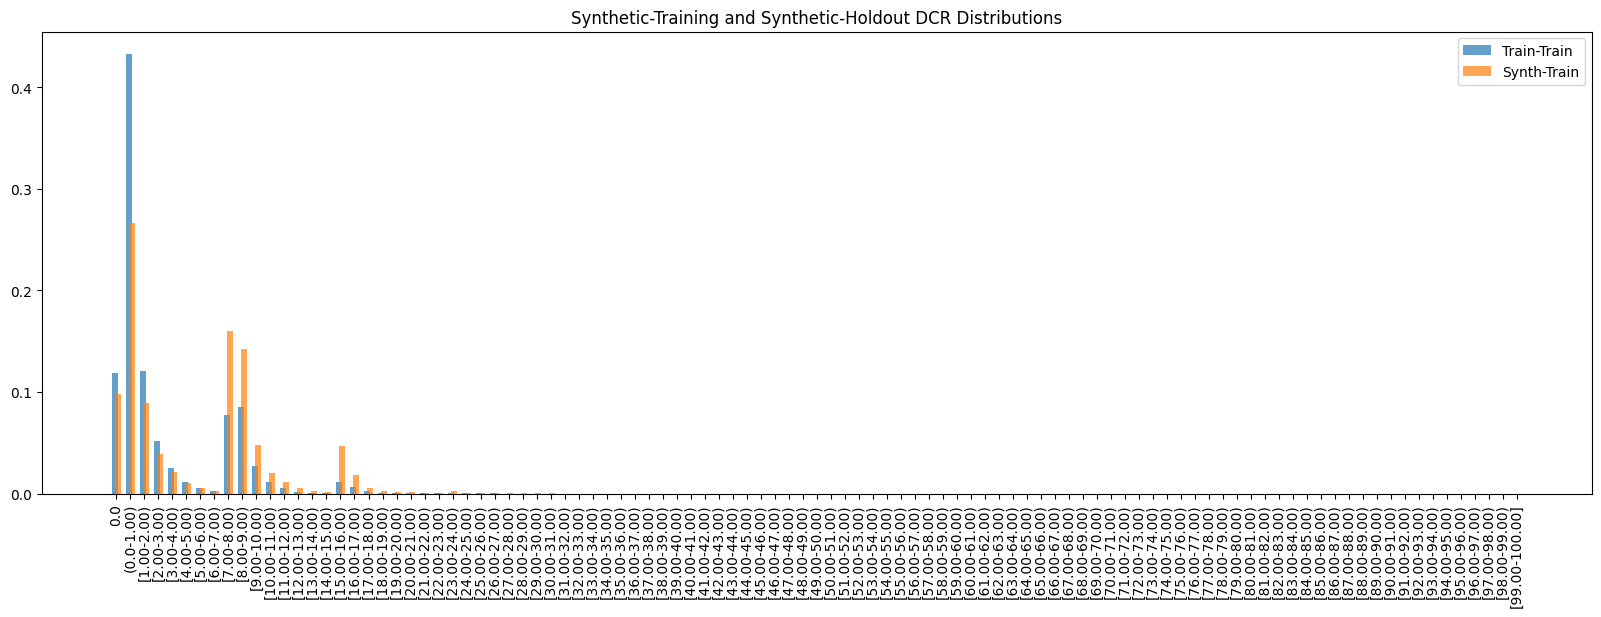

In [78]:
def display_DCR_results(training_metrics, synthetic_metrics, synthetic_training_metrics, synthetic_holdout_metrics):
    # Display useful DCR stats
    print("            Duplicates stats")
    print("----------------------------------------")
    print(pd.DataFrame({'Training':[f"{training_metrics['training_duplicates']}", f"{round(training_metrics['training_duplicates_percentage'],2)} %", f"{training_metrics['training_unique_duplicates']}", f"{round(training_metrics['training_unique_duplicates_percentage'],2)} %"], 
                        'Synthetic':[f"{synthetic_metrics['synthetic_duplicates']}", f"{round(synthetic_metrics['synthetic_duplicates_percentage'],2)} %", f"{synthetic_metrics['synthetic_unique_duplicates']}", f"{round(synthetic_metrics['synthetic_unique_duplicates_percentage'],2)} %"]}, 
                        index=["Duplicates", "Duplicates %", "Unique duplicates", "Unique duplicates %"]))


    print(f"\n\nSynthetic-Training clones: {synthetic_training_metrics['synth_train_clones']} ({synthetic_training_metrics['synth_train_clones_percentage']:.2f} %)")

    print("\n\n                   DCR stats")
    print("----------------------------------------------")
    print(pd.DataFrame({'Synthetic-Training ': synthetic_training_metrics['dcr_synth_train_stats'], 'Synthetic-Holdout': synthetic_holdout_metrics['dcr_synth_holdout_stats']}))

    print("\n\nSynthetic-Training vs. Synthetic-Holdout Test (DCR share): {:.2f} %".format(synthetic_holdout_metrics['synth_holdout_test']))

def plot_DCR_results(training_metrics, synthetic_training_metrics):
    # Plot DCR synth-train and synth-holdout histograms
    labels = training_metrics['dcr_train_train_hist']['bins']
    train_train_counts = training_metrics['dcr_train_train_hist']['counts'] / np.sum(training_metrics['dcr_train_train_hist']['counts'])
    synth_train_counts = synthetic_training_metrics['dcr_synth_train_hist']['counts'] / np.sum(synthetic_training_metrics['dcr_synth_train_hist']['counts'])
    X_axis = np.arange(len(labels))
    plt.figure(figsize=(20,6))
    plt.xticks(X_axis, labels, rotation='vertical')
    plt.bar(X_axis-0.1, train_train_counts, 0.4, label = 'Train-Train', alpha=0.7)
    plt.bar(X_axis+0.1, synth_train_counts, 0.4, label = 'Synth-Train', alpha=0.7)
    plt.legend()
    plt.title("Synthetic-Training and Synthetic-Holdout DCR Distributions")

display_DCR_results(training_metrics, synthetic_metrics, synthetic_training_metrics, synthetic_holdout_metrics)
plot_DCR_results(training_metrics, synthetic_training_metrics)

#### 1.1.2 Membership Inference Attack
The **Membership Inference Test** is a critical evaluation used to estimate the risk of revealing membership information in a dataset.<br> 
This test assesses how well an adversary, armed with certain prior knowledge, could infer whether specific records were part of the original training dataset used to generate the synthetic data.

**Why Membership Inference Poses a Privacy Risk**<br>

A malicious attacker who has prior knowledge of one or more records in the original dataset can use the membership inference test to determine if those records were part of the training dataset used to generate the synthetic data.<br> 
This process can compromise the privacy of the original dataset in several ways:

- *Revealing Sensitive Information*:

    If the synthetic dataset retains too much similarity to the original data, the attacker can infer sensitive details about individuals or entities, such as health records, financial transactions, or other private attributes.
- *Increased Risk of Reidentification*:

    The more closely the synthetic data resembles the training data, the higher the risk that an attacker can reidentify individuals within the synthetic dataset, thus violating their privacy.
- *Erosion of Anonymization*:

    The goal of synthetic data is to anonymize original records while maintaining data utility. However, if membership inference is successful, it undermines the very purpose of synthetic data generation by exposing private information.

Synthetic data generation techniques must ensure that records in the synthetic dataset cannot be linked back to the original dataset with high confidence.

**How the Membership Inference Test Works**

1. *Distance to the Closest Record (DCR)*:

    The test calculates the **DCR** (**Distance to the Closest Record**) for each record in the adversary dataset by measuring its distance to all records in the synthetic dataset.<br>
    The DCR quantifies how closely an adversary’s known records resemble records in the synthetic dataset.
2. *Threshold-Based Risk Evaluation*:

    A set of distance thresholds is applied to the DCR values. These thresholds determine whether a record is considered sufficiently "close" to indicate membership in the original dataset.<br>
    For each threshold, the test computes precision scores, which reflect how accurately the synthetic dataset can be linked back to specific records in the adversary dataset.
3. *Privacy Risk Assessment*:

    If many records from the adversary dataset are identified with high precision (low DCR values), this indicates that the synthetic data strongly resembles the original data, increasing the risk of membership inference.<br>
    Conversely, if the precision scores are low across thresholds, it suggests that the synthetic dataset is well-anonymized, reducing the likelihood of successful membership inference.

    The **MI Mean Risk score** is computed as $(precision - 0.5) * 2$.<br>
    MI Risk Score smaller than 0.2 (20%) are considered to be very LOW RISK of disclosure due to membership inference.

In [74]:
print("Membership Inference Test")
print("  Adversary Distance Thresholds: {}".format(membership_inference_test['adversary_distance_thresholds']))
print("  Adversary Precision Score: {}".format(membership_inference_test['adversary_precisions']))
print("  Membership Inference Mean Risk Score: {:.4f}".format(membership_inference_test['membership_inference_mean_risk_score']))

Membership Inference Test
  Adversary Distance Thresholds: [0.013881421647965908, 0.003161222208291292, 0.002107481472194195, 0.0]
  Adversary Precision Score: [0.500615763546798, 0.5294888597640891, 0.5472175379426644, 0.5]
  Membership Inference Mean Risk Score: 0.0387
